In [1]:
from camo_worms_utils import *

from itertools import product

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


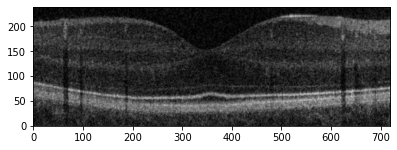

In [2]:
# Read, crop and display image and stats

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

# Initialise clew of 40 and draw

GENERATIONS = 50000
POPULATION = 1000
PERCENT = 10

#clew = initialise_clew(40, image.shape, (40, 30, 1))
clew = initialise_clew(POPULATION, image.shape, (40, 30, 1))


#drawing = Drawing(image)
#drawing.add_worms(clew)
#drawing.show()

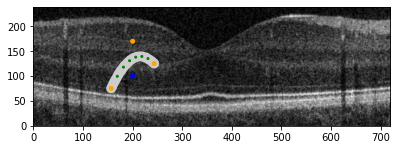

In [3]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
drawing = Drawing(image)
drawing.add_worms(worm)
drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
drawing.add_dots(worm.control_points(),color='orange')
drawing.add_dots((200,100), color='blue')



drawing.show(save='bezier.png')

In [4]:
""" OLD METHOD
def average_distance(worm, clew):
    dists = []

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist """

"""
def count_overlaps(worm_idx, clew):

    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        if i is not worm_idx:
            # base off of three intermediate points
            # i.e. add one to count if any points are too close
            points_worm = worm.intermediate_points()
            points_other = clew[i].intermediate_points()
            
            combos = list(product(points_worm, points_other))

            for point_worm, point_other in combos:
                euclid_dist = np.linalg.norm(
                    np.array(point_worm)-np.array(point_other)
                )
                # print(f"Points {point_worm}, {point_other}")
                # print(f"Widths {worm.width}, {clew[i].width}")
                # print(f"Dist {euclid_dist}\n")
                if euclid_dist < worm.width + clew[i].width:
                    # theyre touching
                    count += 1
                    break

    proportion = count/(len(clew)-1)
    # print(f"Count: {count}, Proportion: {proportion}")

    return proportion
"""

""" OLD METHOD
def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave """

""" def average_contrast(worm, image):
    # Gather points at boundary of worm to test
    total_contrast = 0
    count = 0

    for edge_point in worm.edge_points(5):
        # Get image colour at boundary
        x = round(edge_point[0])    # Only whole indexes are allowed
        y = round(edge_point[1])    # The maths that finds edge points can get decimals
        image_colour = worm.colour_at_xy( x, y, image)
        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))
        # Calculate contrast by comparing worm body colour with edge colour
        # Assume worm is similar colour to background because of score function
        total_contrast = total_contrast + abs(image_colour - worm.colour)
        count = count + 1

    if(count > 0):
          contrast_ave = total_contrast/count # To get average, divide by 10 samples
    else: contrast_ave=0
    return contrast_ave """



' def average_contrast(worm, image):\n    # Gather points at boundary of worm to test\n    total_contrast = 0\n    count = 0\n\n    for edge_point in worm.edge_points(5):\n        # Get image colour at boundary\n        x = round(edge_point[0])    # Only whole indexes are allowed\n        y = round(edge_point[1])    # The maths that finds edge points can get decimals\n        image_colour = worm.colour_at_xy( x, y, image)\n        #print("Colour difference at (x,y)=({},{})\nWorm Colour = {}\nImage Colour ={}".format(x,y, worm.colour, image_colour))\n        # Calculate contrast by comparing worm body colour with edge colour\n        # Assume worm is similar colour to background because of score function\n        total_contrast = total_contrast + abs(image_colour - worm.colour)\n        count = count + 1\n\n    if(count > 0):\n          contrast_ave = total_contrast/count # To get average, divide by 10 samples\n    else: contrast_ave=0\n    return contrast_ave '

The Sorting function

In [5]:
# # a sorting function
# def eval_worm(worm_idx, clew_var=clew, image_var=image, size_weight=100, overlap_weight=1300, colour_weight=1500, contrast_weight=150, print_results=False):
#     # NOTE: image and clew is hardcoded, as variables can't be passed through sort(key=...)

#     score = 0

#     worm = clew_var[worm_idx]

#     #contrast_weight=80
    
#     # ------------ Internal Knowledge ------------
    
#     # --- Size ---
#     # Big Worms to counteract 1 pixel worms being highest score
#     size = worm.approx_length() / image_var.shape[1] # size as a percentage of image width
#     size_comp = size_weight*size
    
    
#     # ------------ Group Knowledge ------------
    
#     # --- Average Distance ---
#     """old method
#     #dist_weight=0.2
#     #average_dist = average_distance(worm, clew_var)
#     #dist_comp = dist_weight * average_dist 
    
#     average_dist = average_distance(worm, clew_var)
#     # option1
#     # want worms spread out (add small constant to prevent divide by 0)
#     # take min with 1 to keep on scale 0 to 1
#     inversed = min(1/(average_dist+0.00001), 1)
#     # define as 0 for some ideal distance apart (should define it better than max(image.shape))
#     #if average_dist > max(image.shape):
#     #    inversed = 0
#     ## define as 1 for too far apart
#     #if average_dist > max(image.shape)*1.05:
#     ##    inversed = 1
#     dist_comp = dist_weight * inversed
#     """

#     #dist_comp = 0
    
#     proportion = count_overlaps(worm_idx, clew)
#     overlap_comp = overlap_weight * proportion


    
#     # ------------ Environmental Knowledge ------------

#     # --- Colour Difference ---
#     # Compare to colour (inverse)
#     #colour_diff = average_colour_diff(worm, image_var)

#     colour_score = np.abs(worm.get_mean_colour_under(image) - worm.colour)
#     colour_comp = colour_weight* -colour_score


#     # --- Contrast ---
#     # Find hard edges around worm
#     #contrast = average_contrast(worm, image)
#     contrast = 0
#     contrast_comp = contrast_weight*contrast


#     # ------------ Final Calibration ------------

#     # Sort doesn't work with decimals
#     score = round( (size_comp + overlap_comp + colour_comp + contrast_comp)*1000 )

#     if(score < 0):
#         score = 0 # No negatives allowed for sorting. Assume anything with a score of 0 will get discarded.

#     if(print_results):
#         print( "    Score: (sz={print_size}) + (dist={print_dist}) + (col={print_colour}) + (con={print_contrast}) = {print_score}".format(
#             print_size=size_comp,
#             print_dist = overlap_comp,
#             print_colour=colour_comp,
#             print_contrast = contrast_comp,
#             print_score = score) )
    
#     return score

# Helper Methods

### Size Calcs

In [6]:
def calc_size(worm, image):
    # --- Size ---
        # Big Worms to counteract 1 pixel worms being highest score
        size = worm.approx_length() / image_var.shape[1] # size as a percentage of image width
        return size


def calc_ideal_width(worm):
    # lets just say we want worms to be around 5 px wide
    # scale so that 5px => low score, lower or higher width => high score
    ideal_width = 10
    dist_from_ideal = np.abs(worm.width - ideal_width)

    return dist_from_ideal

def calc_too_small(worm):
    # What if we just want bigger than a certain size
    min_width = 3
    min_length = 4

    # Big score: (4-20))/4  = -4, maxed to 0
    # Same Size: (4-4)/4    = 0
    # Small score: (4-1)/4  = 0.75
    wid_diff = (min_width - worm.width)/min_width
    wid_diff = max(0, wid_diff) # Remove negative vals
    
    len_diff = (min_length - worm.approx_length() )/min_length
    len_diff = max(0, len_diff) # Remove negative vals


    #print("Testing too small. Worm wid*len: {wid}*{len}\n    wid_diff={w_d}, len_diff={l_d}".format(
    #     len=round(worm.approx_length(),2),
    #     wid=round(worm.width,2),
    #     w_d=round(wid_diff,2),
    #     l_d=round(len_diff,2)
    #    )
    #)

    combined = wid_diff*0.5 + len_diff*0.5 # scale to be between 0 and 1, combined

    return combined





def off_screen_penalty(worm, image):
    off_screen_penalty = 0
    xmin, xmax = [0, image.shape[0]]
    ymin, ymax = [0, image.shape[1]]
    if(worm.x > xmin
        and worm.x < xmax
        and worm.y > ymin
        and worm.y < ymax ):
        off_screen_penalty = 1
    return off_screen_penalty

### Distance Calcs
count_overlaps():
This method counts overlaps with other worms. It was useful to push worms apart without forcing large spaces.


average_distance():
This method counts the euclidian distance to each other worm in the clew, then averages it.

It generally pushed worms to the edges of the image, as it has no maximum value.

In [7]:
def count_overlaps(worm_idx, clew):
    # count-based - get proportion of other worms "touching" this worm
    # define "touching" as dist to other point is less than this.width+other.width
    count = 0
    for i in range(len(clew)):
        if i is not worm_idx:
            # base off of three intermediate points
            # i.e. add one to count if any points are too close
            points_worm = worm.intermediate_points()
            points_other = clew[i].intermediate_points()
            
            combos = list(product(points_worm, points_other))

            for point_worm, point_other in combos:
                euclid_dist = np.linalg.norm(
                    np.array(point_worm)-np.array(point_other)
                )
                # print(f"Points {point_worm}, {point_other}")
                # print(f"Widths {worm.width}, {clew[i].width}")
                # print(f"Dist {euclid_dist}\n")
                if euclid_dist < worm.width + clew[i].width:
                    # theyre touching
                    count += 1
                    break
    proportion = count/(len(clew)-1)
    # print(f"Count: {count}, Proportion: {proportion}")
    return proportion




def average_distance(worm, clew):
    dists = []

    for i in range(len(clew)):
        # print("Distance: ({x1},{y1}) to ({x2},{y2})".format(x1=worm.x, y1=worm.y, x2=clew[i].x, y2=clew[i].y))
        euclid_dist = np.linalg.norm(np.array((worm.x, worm.y))-np.array((clew[i].x, clew[i].y)))
        # print(f"Worm centre ({worm.x}, {worm.y})")
        # print(f"Other worm centre ({clew[i].x}, {clew[i].y})")
        # print(f"Dist: {euclid_dist}")
        #print("euclid_dist:{}".format(euclid_dist))
        if(euclid_dist != 0):
            dists.append(euclid_dist)

        # don't bother checking if it's the same worm. It will just be a distance of 0.

    if(dists):  # not empty
        avg_dist = np.mean(dists)
    else:
        avg_dist = 0
        print("Nothing in list. Len={}".format(len(clew)))

    return avg_dist

### Colour Functions
average_colour_diff: 
Fast results, but only calculated along the centerline, and did not account for the width of the worm.

colours_under():
This gave the best colour results by calcing colour at every pixel within a worm, but was slower.

In [8]:
def average_colour_diff(worm, image):

    # Range of 10 t values to gather points for
    t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9, 1.0]

    #print(t_range)

    total_colour_diff = 0
    count = 0

    for t in t_range:
        image_colour = worm.colour_at_t( t, image )
        if(image_colour > -1): # If it returns -1, it means the point is outside the image
            count = count + 1
            total_colour_diff = total_colour_diff + abs(worm.colour - image_colour)
        else:
            # assume maximum difference as penalty
            count = count + 1
            total_colour_diff = total_colour_diff + 255

    #print(total_colour_diff)
    if(count > 0):
          colour_diff_ave = total_colour_diff/count # To get average, divide by 10 samples
    else: colour_diff_ave=0
    return colour_diff_ave


def old_colours_diff_under(worm, image):
    colours_under = worm.get_colour_under(image)
    if colours_under is not None:
        # we want worms to match mean colour underneath them
        colour_diff_under = np.abs(np.mean(colours_under) - worm.colour)

        return colour_diff_under 
    
    else:
        # penalise if none
        return 1
    
def colours_diff_under(worm, image):
    colours_under = worm.get_colour_under(image)
    if colours_under is not None:
        # we want worms to match mean colour underneath them

        # test every point instead of just mean
        colour_diff_under = abs(np.mean(colours_under - worm.colour))

        #colour_diff_under = np.abs(np.mean(colours_under) - worm.colour)#

        return colour_diff_under 
    
    else:
        # penalise if none
        return 1

def colours_under(worm, image):
    colours_under = worm.get_colour_under(image)
    colours_around = worm.get_colour_around(image)
    if colours_under is not None and colours_around is not None:
        # we want worms to match mean colour underneath them
        colour_diff_under = np.abs(np.mean(colours_under) - worm.colour)

        # want small colour stdev under the worm
        # 6.25 to scale to [0,1]
        # note - could extract scaling factor to be own function of image mean colour - see test_colour_std.ipynb
        colour_std = np.std(colours_under)*6.25

        # want colour around to be different from under
        colour_diff_around = np.abs(np.mean(colours_under) - np.mean(colours_around))
        # do 1-difference so that we minimising means increasing difference (i.e. 0 means big diff, 1 means no diff)
        colour_diff_around = 1-colour_diff_around

        # equal weighting
        # enviro_score = 0.5*colour_diff + 0.5*colour_std
        enviro_score = 0.5*colour_std + 0.5*colour_diff_around
    else:
        # penalise if none
        enviro_score = 1
    
    return enviro_score

### Evan's cost func

In [9]:
def get_cost(image, worm_idx: int, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    worm = clew[worm_idx]
    return get_cost_worm(image, worm, clew, w_internal, w_group, w_environment)

# Alternate version to use for worms not in the clew
def get_cost_worm(image, worm: Camo_Worm, clew: list[Camo_Worm], w_internal, w_group, w_environment):
    
    # ********************
    # internal

    # Evan Version
    #off_screen_pen = off_screen_penalty(worm, image)
    #dist_from_ideal = calc_ideal_width(worm)
    #internal_score = dist_from_ideal + off_screen_pen

    # Seb Version
    too_small = calc_too_small(worm)
    internal_score = too_small

    # ********************
    # group
    #proportion = count_overlaps(worm_idx, clew)
    proportion = 0
    group_score = proportion

    # ********************
    # environment

    enviro_score = colours_diff_under(worm, image)
    #enviro_score = old_colours_diff_under(worm, image)
    #enviro_score = colours_under(worm, image)

    # ********************
    
    # FINAL SCORE
    total_score = internal_score*w_internal + group_score*w_group + enviro_score*w_environment

        # Penalty for going off screen:
    off_screen_pen = off_screen_penalty(worm, image)
    if(off_screen_pen == 1):
        total = 100

    # return total weighted and individual scores
    return (
        total_score,
        internal_score*w_internal,
        group_score*w_group,
        enviro_score*w_environment
    )

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


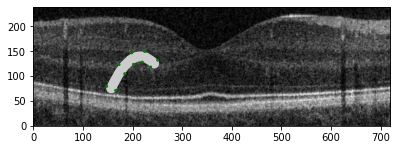

(240, 720)


In [10]:
# Draw a single worm along with control points and some sample points

worm = Camo_Worm(200, 100, 50, np.pi/6, 70, np.pi/3, 10, 0.8)

t_range = [t / 10 for t in range(0, 11, 1)] # [0.1, 0.2, 0.3... 0.9]
print(t_range)

# coords = []
# for t in t_range:
#     print(worm.coords_at_t(t))
#     coords.append(  worm.coords_at_t(t) )

#print(coords)

drawing = Drawing(image)
drawing.add_worms(worm)
#drawing.add_dots(coords, radius=2, color='green')
drawing.add_dots(worm.edge_points(5), radius=2, color='green')

drawing.show(save='bezier.png')


print(image.shape)
# reversed as [y, x]

In [11]:
def get_fittest(image, clew: list[Camo_Worm], w_internal: float=1.0, w_group: float=1.0, w_environment: float=1.0):
    #scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    #scores = [eval_worm(i) for i, worm in enumerate(clew)]
    scores = [get_cost(image, i, clew, w_internal, w_group, w_environment) for i, worm in enumerate(clew)]
    #print(scores)
    #print(scores)
    costs = [score[0] for score in scores]
    internal_scores = [score[1] for score in scores]
    group_scores = [score[2] for score in scores]
    enviro_scores = [score[3] for score in scores]
    sorted_clew = sorted(zip(clew, costs), key=lambda x: x[1])
    #sorted_clew = sorted(zip(clew, scores), key=lambda x: x[1])
    """
    return (
        [worm for worm,cost in sorted_clew[:top_n]],
        np.mean(costs),
        np.mean(internal_scores),
        np.mean(group_scores),
        np.mean(enviro_scores)
    )
    """
    return (    
        [worm for worm,cost in sorted_clew],
        [np.min(costs), np.mean(costs), np.max(costs)],
        [np.min(internal_scores), np.mean(internal_scores), np.max(internal_scores)],
        [np.min(group_scores), np.mean(group_scores), np.max(group_scores)],
        [np.min(enviro_scores), np.mean(enviro_scores), np.max(enviro_scores)],
    )
    

    """
    return (    
        [worm for worm,cost in sorted_clew],
        np.mean(costs),
        np.mean(internal_scores),
        np.mean(group_scores),
        np.mean(enviro_scores)
    )
    """

# STEADY STATE GENETIC

In [12]:
# w_internal=1.0
# w_group=1.0
# w_environment=1.0



# print("--------HYPER_PARAMETERS--------")
# print("GENERATIONS: {}\n POPULATION: {}\n PERCENT: {}\n ".format(GENERATIONS, POPULATION, PERCENT))


# # hardcode 10 generations
# for gen in range(GENERATIONS):

#     # sort in order with a scoring function
#     clew, ave_scores, ave_int, ave_gro, ave_env = get_fittest(image, clew)

#     # Every 10 generations, give summary
#     if(gen % 100 == 0):
#         print("--------Generation {}, len={}, ave={}------------".format(
#             gen,
#             len(clew),
#             round(ave_scores[1],3)))

#     # Every 100 generations, give image
#     if(gen % 100 == 0):

#         #drawing = Double_Drawing(image)
#         drawing = Drawing(image)
#         drawing.add_worms(clew)

#         best_worm = clew[0]
#         # print("Best Worm:")
#         # #eval_worm(best_worm, print_results=True)
#         # get_cost(image, i, clew, w_internal, w_group, w_environment)
#         # #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
#         # #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
#         drawing.add_worms(best_worm) # put it on top
#         #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
#         drawing.add_dots(best_worm.edge_points(5), 2, color="green")

#         drawing.show()

#     # print("Returned clew len: {}\nAverage Scores: {}\nAverage Internal Scores: {}\nAverage Group Scores: {}\nAverage Environ Scores: {}\n".format(
#     #       len(clew),
#     #       ave_scores,
#     #       ave_int,
#     #       ave_gro,
#     #       ave_env
#     #       )
#     # )


#     # # Test of first 5 values
#     # print("Test first 5 vals")
#     # print("i | Score | Internal | Group | Environment")
#     # for i in range(5):
#     #     #current_worm = clew[i]
#     #     # score = eval_worm(current_worm_idx, print_results=True)
#     #     scores = get_cost(image, i, clew, w_internal, w_group, w_environment)
#     #     #print("Worm {}: {}".format(i,scores[0]))
#     #     print("{i_p} | {score} |   {int}  |  {gro}  | {env} ".format(
#     #         i_p=i,
#     #         #score=  round(scores[0], 3),
#     #         #int=    round(scores[1], 3),
#     #         #gro=    round(scores[2], 3),
#     #         #env=    round(scores[3], 3)
#     #         score=  round(scores[0], 3),
#     #         int=    round(scores[1], 3),
#     #         gro=    round(scores[2], 3),
#     #         env=    round(scores[3], 3)
#     #     ))

#     """ drawing = Double_Drawing(image)
#     drawing.add_worms(clew)

#     best_worm = clew[0]
#     # print("Best Worm:")
#     # #eval_worm(best_worm, print_results=True)
#     # get_cost(image, i, clew, w_internal, w_group, w_environment)
#     # #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
#     # #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
#     drawing.add_worms(best_worm) # put it on top
#     #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
#     drawing.add_dots(best_worm.edge_points(5), 2, color="green")

#     drawing.show() """
       
    
#     """ # get top 10% to start next generation
#     ten_perc = round( (PERCENT/100) * POPULATION )

#     new_clew = []
#     for i in range(ten_perc):
#         new_clew.append( clew[i] )


#     print("{percent}% of {population} = {ten}. New_Clew Parents: {new_clew_len}".format(percent=PERCENT, population=POPULATION, ten=ten_perc, new_clew_len=len(new_clew)))
    
#     # use top 10% to generate the rest of the population
    
#     for i in range( POPULATION - ten_perc ): # get remaining 90% of pop
    
#         rand1 = rng.integers(0, ten_perc) # pick one of the top 10%
#         parent1 = clew[rand1]

#         rand2 = rng.integers(0, ten_perc)
#         parent2 = clew[rand2]

#         # Reroll if trying to self-mate
#         while(rand1 == rand2):
#             if(not (POPULATION - ten_perc)>1):
#                 # There is only one possible parent.
#                 break
#             #SELF-MATING: Reroll.
#             rand2 = rng.integers(0, ten_perc)

#         #print("Mate {} with {}".format(rand1, rand2))

#         child = parent1.mate(parent2, image)
#         new_clew.append(child)
    
#     # replace the previous generation
#     clew = new_clew """



#     # SELECT PARENTS:

#     rand1 = rng.integers(0, POPULATION)
#     parent1 = clew[rand1]

#     rand2 = rng.integers(0, POPULATION)
#     parent2 = clew[rand2]

#     child1 = parent1.mate(parent2, image)
#     child1_score = get_cost_worm(image, child1, clew, w_internal, w_group, w_environment)[0]
#     #child2 = parent1.mate(parent2, image)

#     worst_member_score = get_cost(image, POPULATION-1, clew, w_internal, w_group, w_environment)[0]
#     #print("Child score:{}".format(child1_score))
#     #print("Worst member score:{}".format(worst_member_score))

#     if( child1_score < worst_member_score):
#         #print("Child replaces worst member")
#         # print("Child replaces worst member: Child={}, worst={}".format(
#         #     round(child1_score,3),round(worst_member_score,3))
#         #     )
#         # Replace worst member
#         clew[POPULATION-1] = child1
    
#     # else:
#     #     print("No Replacement: Child={}, worst={}".format(
#     #         round(child1_score,3),round(worst_member_score,3))
#     #         )

    
#     #print(len(clew))
    
    

# Sorted Version

--------HYPER_PARAMETERS--------
GENERATIONS: 10000
 POPULATION: 1000
 PERCENT: 10
 
--------Generation 0, len=1000, ave=0.47------------


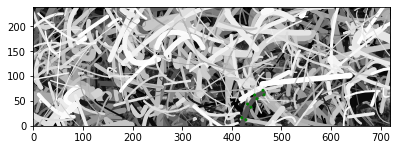

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.003 |   0.0  |  0.0  | 0.003 
2 | 0.003 |   0.0  |  0.0  | 0.003 
3 | 0.003 |   0.0  |  0.0  | 0.003 
4 | 0.004 |   0.0  |  0.0  | 0.004 
--------Generation 500, len=1000, ave=0.277------------


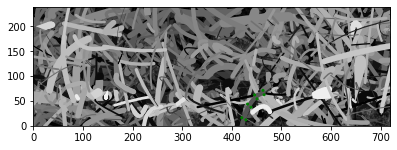

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.003 |   0.0  |  0.0  | 0.003 
2 | 0.003 |   0.0  |  0.0  | 0.003 
3 | 0.003 |   0.0  |  0.0  | 0.003 
4 | 0.004 |   0.0  |  0.0  | 0.004 
--------Generation 1000, len=1000, ave=0.181------------


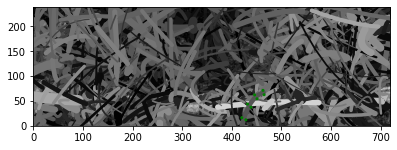

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.001 |   0.0  |  0.0  | 0.001 
2 | 0.001 |   0.0  |  0.0  | 0.001 
3 | 0.001 |   0.0  |  0.0  | 0.001 
4 | 0.001 |   0.0  |  0.0  | 0.001 
--------Generation 1500, len=1000, ave=0.122------------


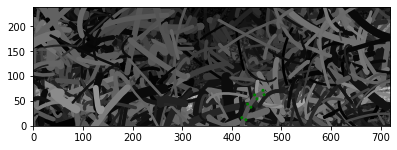

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.001 |   0.0  |  0.0  | 0.001 
2 | 0.001 |   0.0  |  0.0  | 0.001 
3 | 0.001 |   0.0  |  0.0  | 0.001 
4 | 0.001 |   0.0  |  0.0  | 0.001 
--------Generation 2000, len=1000, ave=0.086------------


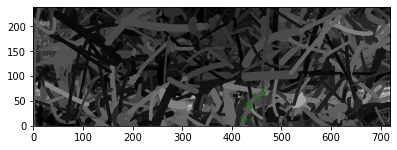

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.001 |   0.0  |  0.0  | 0.001 
3 | 0.001 |   0.0  |  0.0  | 0.001 
4 | 0.001 |   0.0  |  0.0  | 0.001 
--------Generation 2500, len=1000, ave=0.06------------


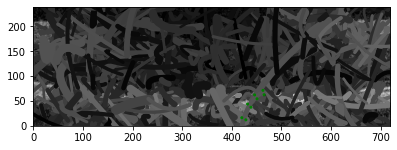

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.001 |   0.0  |  0.0  | 0.001 
--------Generation 3000, len=1000, ave=0.043------------


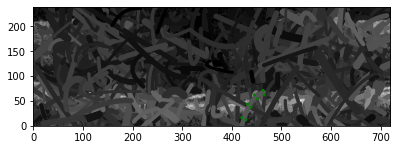

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 3500, len=1000, ave=0.032------------


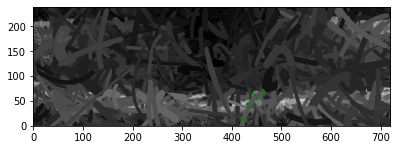

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 4000, len=1000, ave=0.024------------


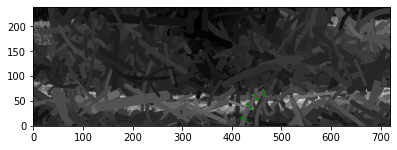

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 4500, len=1000, ave=0.019------------


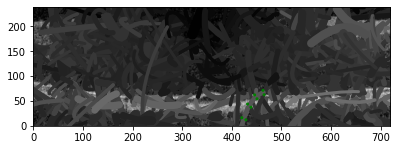

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 5000, len=1000, ave=0.015------------


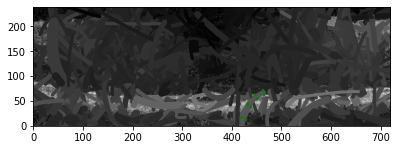

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 5500, len=1000, ave=0.012------------


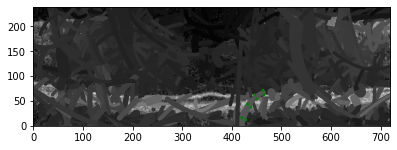

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 6000, len=1000, ave=0.01------------


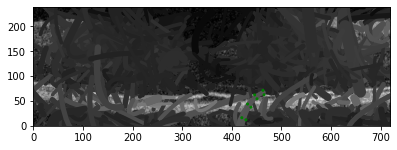

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 6500, len=1000, ave=0.009------------


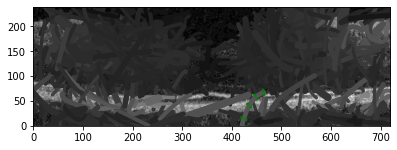

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 7000, len=1000, ave=0.007------------


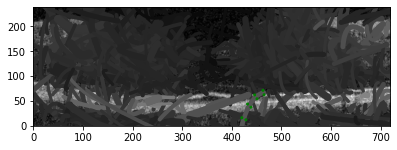

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 7500, len=1000, ave=0.006------------


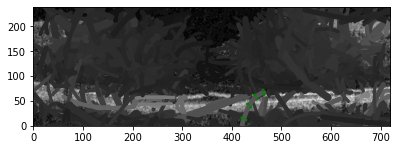

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 8000, len=1000, ave=0.006------------


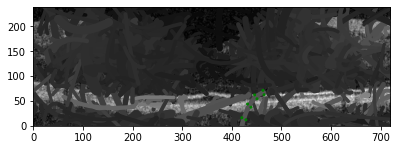

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 8500, len=1000, ave=0.005------------


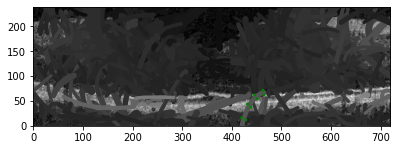

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 9000, len=1000, ave=0.005------------


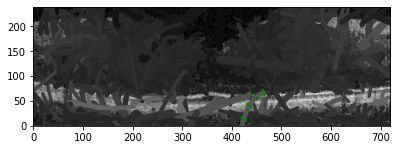

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 
--------Generation 9500, len=1000, ave=0.004------------


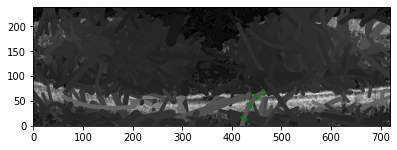

Test first 5 vals
i | Score | Internal | Group | Environment
0 | 0.001 |   0.0  |  0.0  | 0.001 
1 | 0.0 |   0.0  |  0.0  | 0.0 
2 | 0.0 |   0.0  |  0.0  | 0.0 
3 | 0.0 |   0.0  |  0.0  | 0.0 
4 | 0.0 |   0.0  |  0.0  | 0.0 


In [13]:
w_internal=1.0
w_group=1.0
w_environment=1.0


class Scored_Worm:
    def __init__(self, worm, score):
        self.worm = worm
        self.score = score


def insert_sorted(sorted_clew, scored_worm):
    #print("try to add worm")
    i = len(sorted_clew) - 1 # start at end
    while(True):
        if(sorted_clew[i].score > scored_worm.score and i > 0):
            i = i - 1
        else:
            break
    
    i = i+1 # The loops goes one more than it should
    """ print("--------")
    print("{}th Worm score = {}".format(i-1, sorted_clew[i-1].score))
    print("New Worm score = {}".format(scored_worm.score))
    print("{}th Worm score = {}".format(i, sorted_clew[i].score))
    print("{}th Worm score = {}".format(i+1, sorted_clew[i+1].score))
    print("Inserting worm at {}".format(i)) """

    sorted_clew.insert(i, scored_worm)

    """
    print("After Insert:")
    print("{}th Worm score = {}".format(i-1, sorted_clew[i-1].score))
    print("{}th New Worm score = {}".format(i, sorted_clew[i].score))
    print("{}th Worm score = {}".format(i+1, sorted_clew[i+1].score))
    print("--------")
    """

def convert_clew(sorted_clew):
    # Convert to normal worm objects
    normal_clew = []
    for scored_worm in sorted_clew:
        worm = scored_worm.worm # get the normal object out
        normal_clew.append(worm)
    return normal_clew


# Initial Sort!!!
# sort in order with a scoring function
clew, ave_scores, ave_int, ave_gro, ave_env = get_fittest(image, clew)


# Convert to sorted list
sorted_clew = []
for worm in clew:
    worm_cost = get_cost_worm(image, worm, clew, w_internal, w_group, w_environment)[0]
    new_sorted_worm = Scored_Worm(worm, worm_cost)
    sorted_clew.append(new_sorted_worm)


print("--------HYPER_PARAMETERS--------")
print("GENERATIONS: {}\n POPULATION: {}\n PERCENT: {}\n ".format(GENERATIONS, POPULATION, PERCENT))


# 5 Updates
Update_Total = 0.2*Generations

# hardcode 10 generations
for gen in range(GENERATIONS):

    # update the clew
    normal_clew = convert_clew(sorted_clew)

    # Every 10 generations, give summary
    if(gen % Update_Total == 0):

        scores = []
        for scored_worm in sorted_clew:
            scores.append(scored_worm.score)
        scores_ave = round(np.mean(scores), 3)

        print("--------Generation {}, len={}, ave={}------------".format(
            gen,
            len(sorted_clew),
            scores_ave
            )
        )

        #drawing = Double_Drawing(image)
        drawing = Drawing(image)
        drawing.add_worms(normal_clew)

        best_worm = normal_clew[0]
        # print("Best Worm:")
        # #eval_worm(best_worm, print_results=True)
        # get_cost(image, i, clew, w_internal, w_group, w_environment)
        # #print("    Best environment worm point: x %2d, y %2d" %(best_worm.x, best_worm.y))
        # #print("    Length: %.2f, width %.2f and colour: %.2f" % (best_worm.approx_length(), best_worm.width, best_worm.colour* 255 ))
        drawing.add_worms(best_worm) # put it on top
        #drawing.add_dots(best_worm.intermediate_points(5), 2, color="orange")
        drawing.add_dots(best_worm.edge_points(5), 2, color="green")

        drawing.show()


        # Test of first 5 values
        print("Test first 5 vals")
        print("i | Score | Internal | Group | Environment")
        for i in range(5):
            scores = get_cost(image, i, normal_clew, w_internal, w_group, w_environment)
            #print("Worm {}: {}".format(i,scores[0]))
            print("{i_p} | {score} |   {int}  |  {gro}  | {env} ".format(
                i_p=i,
                #score=  round(scores[0], 3),
                #int=    round(scores[1], 3),
                #gro=    round(scores[2], 3),
                #env=    round(scores[3], 3)
                score=  round(scores[0], 3),
                int=    round(scores[1], 3),
                gro=    round(scores[2], 3),
                env=    round(scores[3], 3)
            ))



    # SELECT PARENTS:

    rand1 = rng.integers(0, POPULATION)
    parent1 = sorted_clew[rand1].worm

    rand2 = rng.integers(0, POPULATION)
    parent2 = sorted_clew[rand2].worm

    child1_worm = parent1.mate(parent2, image)
    child1_score = get_cost_worm(image, child1_worm, normal_clew, w_internal, w_group, w_environment)[0]
    child1 = Scored_Worm(child1_worm, child1_score)

    worst_member_score = sorted_clew[POPULATION - 1].score
    #print("Child score:{}".format(child1_score))
    #print("Worst member score:{}".format(worst_member_score))

    if( child1_score < worst_member_score):
        #print("Child replaces worst member")
        # print("Child replaces worst member: Child={}, worst={}".format(
        #     round(child1_score,3),round(worst_member_score,3))
        #     )
        # Replace worst member
        #clew[POPULATION-1] = child1
        sorted_clew.pop() # Remove worst worm
        insert_sorted(sorted_clew, child1)
    
    # else:
    #     print("No Replacement: Child={}, worst={}".format(
    #         round(child1_score,3),round(worst_member_score,3))
    #         )

    
    #print(len(clew))
    
    

&copy; Cara MacNish, UWA, 2024